# Hands-on NLP and Naive Bayes

Prepared by Chris Gian for Hack Oregon's Week 
Sources:
- Based mostly on: [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class. 
- Adapted for use with sklearn way of text processing: [Working With Text Data](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
- Hobson Lane's book: [NLP in Action](https://www.manning.com/books/natural-language-processing-in-action)

## Setting up

In [1]:
import requests
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# inline plotting
%matplotlib inline


# Vectorize, Transform
def make_X(data, min_df_in, stopwords, lowercase,ngram):
    vectorizer = CountVectorizer(min_df=min_df_in, stop_words= stopwords, lowercase= lowercase, ngram_range=ngram)
    term_doc_matrix = vectorizer.fit_transform(data)
    term_doc_matrix = term_doc_matrix.todense()
    term_doc_matrix = pd.DataFrame(term_doc_matrix)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(term_doc_matrix)
    tfidf = pd.DataFrame(tfidf.toarray())
    return tfidf, vectorizer, transformer

# Send scores to a google docs
def post_score(name, your_score):
    send = 'https://docs.google.com/forms/d/e/1FAIpQLSfOdYRNhf_z3PsHDxMu-IoqaUbUaI9uSHflExgZuBoC1HNvtQ/formResponse?'    
    send += 'entry.278237990=' + name
    send += '&entry.415269798=' + str(your_score)
    r = requests.post(send)
    print(r)

## Data + Prep

In [2]:
# Read Data
critics = pd.read_csv('resources/critics.csv')
critics = critics[critics.fresh != 'none']
df = critics.copy().dropna()
# split
X = df.quote
y = df.fresh == 'fresh'

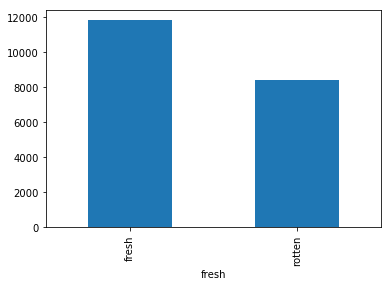

In [3]:
_ = critics.groupby('fresh').size().plot('bar')

## Feature Engineering

At this point you might have employed the following during feature engineering:
1. Dealt with contractions and abbreviations
2. normalized your vocabulary via
    - Case Norming
    - Stemming
    - Lemmatization
3. included a stop words list
    - words to exclude such as "it" or "the" 
4. Parts of Speech Tagging
5. Created "N-Grams" where your token looks like 
    - ["Ice Cream", "New York City"] rather than
    - [New, york, city, ice, cream]
6. Dimensionality reduction
7. included meta data such as time and critic

<br>
<br>
<br>

**(Optional Step) Lemmatization and Parts of Speech Tagging using spacy**
- Current script will create 5 additional columns
- Takes a quite some time for large data frames

Need to load lanaguage model [here](https://spacy.io/docs/usage/models)

In [4]:
import spacy
import en_core_web_md #you have to download this from 
nlp = en_core_web_md.load() 
data_spacy = df

In [5]:
parsed = nlp.pipe(iter(data_spacy['quote']), batch_size=1, n_threads=4)
stop = []
# Create Features
tokens, lemma, parts, stopword = [], [], [], []

for parsed_doc in parsed:
    tokens.append([n.text for n in parsed_doc])
    lemma.append([n.lemma_ for n in parsed_doc])
    parts.append([n.pos_ for n in parsed_doc])
    stopword.append([n.is_stop for n in parsed_doc])

# Assign Parsed into Dataframe
data_spacy['tokens'] = tokens     
data_spacy['tokens_stopwords'] = data_spacy['tokens'].apply(lambda x: [item for item in x if item not in stop])
data_spacy['lemma'] = lemma
data_spacy['pos'] = parts
data_spacy['stopword'] = stopword

# Describe resulting frame
data_spacy.head(2)

,critic,fresh,imdb,publication,quote,review_date,rtid,title,tokens,tokens_stopwords,lemma,pos,stopword
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story,"[So, ingenious, in, concept, ,, design, and, e...","[So, ingenious, in, concept, ,, design, and, e...","[so, ingenious, in, concept, ,, design, and, e...","[ADV, ADJ, ADP, NOUN, PUNCT, NOUN, CCONJ, NOUN...","[False, False, False, False, False, False, Fal..."
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story,"[The, year, 's, most, inventive, comedy, .]","[The, year, 's, most, inventive, comedy, .]","[the, year, 's, most, inventive, comedy, .]","[DET, NOUN, PART, ADV, ADJ, NOUN, PUNCT]","[False, False, False, False, False, False, False]"


<br>
<br>
<br>

**(Optional Step)** Stop words removal

- Note that you can use "english" as an argument. 
- This will take out common english stopwords.
- In addition NLTK has a great english stopwords list too. 
- Finally, you can always supply your own!

In [6]:
stopwords_list = [] # your work here

<br>
<br>
<br>

### Make Features and Create Train Test Split

- Sklearn makes a few things easy for you. Check below arguments I set up. There's more if you explore documentation. You can now:
    - Normalize casing
    - create ngrams using a range (1,1) for single, (1,2) for one to two grams
    - stopwords
    - min_df

In [7]:
x_in = X # YOUR TURN:  <--- Your engineered features go here.
X2, vectorizer_2, transformer_2 = make_X(
    x_in,
    min_df_in= 10, # Option.
    stopwords=stopwords_list, # Option edit from above.
    lowercase = False, # Option.
    ngram = (1,1) # Option. 
)
# Create Hold data set to judge predictive ability on new data
seed = 100
X_train, X_test,y_train, y_test = train_test_split(X2,y, test_size=0.15, random_state=seed)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12554, 3234), (12554,), (2216, 3234), (2216,))

<br>
<br>
<br>

**(Optional Step)** Dimension Reduction via "truncated svd" also called, "Latent Semantic Indexing"

In [8]:
# svd = TruncatedSVD(n_components=500, n_iter=10, random_state=seed)
# X_train = svd.fit_transform(X_train)  
# X_test = svd.transform(X_test)  
# Note that this must be used as classifier because NB does not take negative values.
# clf = LinearDiscriminantAnalysis() great for using with Latent Semantic Indexing

<br>
<br>
<br>

### Choose your classifier
- Try other classifiers as well

If you're using Naive Bayes. There's a single tuning parameter:

**Alpha:** [From Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)

"If a given class and feature value never occur together in the training data, then the frequency-based probability estimate will be zero. This is problematic because it will wipe out all information in the other probabilities when they are multiplied. Therefore, it is often desirable to incorporate a small-sample correction, called pseudocount, in all probability estimates such that no probability is ever set to be exactly zero. This way of regularizing naive Bayes is called Laplace smoothing when the pseudocount is one, and Lidstone smoothing in the general case."

In [15]:
clf = MultinomialNB(alpha=1) # A smoothing parameter. 
clf.fit(X_train,y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

<br>
<br>
<br>

### Performance

In [16]:
print("Accuracy on Training Data: %f" % clf.score(X_train,y_train))
print("Accuracy on Test Data: %f" % clf.score(X_test,y_test))

Accuracy on Training Data: 0.805162
Accuracy on Test Data: 0.734206


In [17]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_pred= y_pred, y_true=y_test)
cm / cm.sum()

array([[ 0.18501805,  0.20938628],
       [ 0.05640794,  0.54918773]])

In [18]:
print(classification_report(y_pred = y_pred, y_true = y_test))

             precision    recall  f1-score   support

      False       0.77      0.47      0.58       874
       True       0.72      0.91      0.81      1342

avg / total       0.74      0.73      0.72      2216



<br>
<br>
<br>

### Post your score!

In [19]:
name = "Baseline"
result = clf.score(X_test,y_test)
print('%s, Accuracy score of: %f' % (name, result))

Baseline, Accuracy score of: 0.734206


In [20]:
post_score(name = name, your_score = np.round(result,decimals=3))

<Response [200]>
